In [1]:
import torch

seed = 10
device = "mps"

# Data
N = 100
P = 1000
P_eval = 100
C = 10
binarize = True

# Model
H = 500
num_layers = 1
max_steps = 5
init_mode = "zeros"
fc_left = True
fc_right = False

# Couplings
lambda_x = 100.0
lambda_y = 100.0
lambda_l = 4.0
lambda_r = 2.0
lambda_wback = 0.001
lambda_internal = 1.0
lambda_fc = 0.001
J_D = 0.5

# Training
num_epochs = 1
batch_size = 16
# lr_J = 0.05
# lr_W = 0.1
# threshold_hidden = 2.5
# threshold_readout = 5.0
# weight_decay_J = 0.1
# weight_decay_W = 0.02

# Evaluation
eval_interval = 1
skip_representations = True
skip_couplings = False

In [2]:
# Assemble the pieces
# lr = [lr_J] * num_layers + [lr_W] * 2
# weight_decay = [weight_decay_J] * num_layers + [weight_decay_W] * 2
# threshold = [threshold_hidden] * num_layers + [threshold_readout]
lambda_left = [lambda_x] + [lambda_l] * (num_layers - 1) + [1.0]
lambda_right = [lambda_r] * (num_layers - 1) + [lambda_wback] + [lambda_y]

lr = [
    0.05,
    0.0,
    0.5,
]
threshold = [
    1.0,
    7.5,
]
weight_decay = [
    0.02,
    0.0,
    0.005,
]

In [3]:
from src.data import prepare_mnist

train_inputs, train_targets, eval_inputs, eval_targets, projection_matrix = (
    prepare_mnist(
        P * C,
        P_eval * C,
        N,
        binarize,
        seed,
        shuffle=True,
    )
)
train_inputs = train_inputs.to(device)
train_targets = train_targets.to(device)
eval_inputs = eval_inputs.to(device)
eval_targets = eval_targets.to(device)

In [4]:
import os

from src.batch_me_if_u_can import BatchMeIfUCan
from src.handler import Handler

output_dir = "prova"
os.makedirs(output_dir, exist_ok=True)

model_kwargs = {
    "num_layers": num_layers,
    "N": N,
    "C": C,
    "lambda_left": lambda_left,
    "lambda_right": lambda_right,
    "lambda_internal": lambda_internal,
    "J_D": J_D,
    "device": device,
    "seed": seed,
    "lr": torch.tensor(lr),
    "threshold": torch.tensor(threshold),
    "weight_decay": torch.tensor(weight_decay),
    "init_mode": init_mode,
}
if fc_left or fc_right:
    model_kwargs["fc_left"] = fc_left
    model_kwargs["fc_right"] = fc_right
    model_kwargs["lambda_fc"] = lambda_fc
    model_kwargs["H"] = H
    model_cls = BatchMeIfUCan  # noqa: F821
else:
    model_cls = Classifier
model = model_cls(**model_kwargs)
handler = Handler(
    model,
    init_mode,
    skip_representations,
    skip_couplings,
    "prova",
)

### Preliminaries

In [5]:
layer_idx = 0
i = 1

torch.set_printoptions(precision=1, sci_mode=True)
print("Couplings:")
print(model.couplings[layer_idx][:, H * i : H * (i + 1)])
print("Learning rates:")
print(model.lr[layer_idx][:, H * i : H * (i + 1)])
print("Weight decay:")
print(model.weight_decay[layer_idx][:, H * i : H * (i + 1)])
print("Is learnable:")
print(model.is_learnable[layer_idx][:, H * i : H * (i + 1)])

Couplings:
tensor([[5.0e-01, 2.8e-03, 5.5e-03,  ..., -8.7e-02, 5.8e-02, 1.1e-02],
        [1.1e-02, 5.0e-01, 1.1e-02,  ..., 7.0e-02, -3.7e-02, -6.7e-02],
        [-7.4e-02, 6.6e-02, 5.0e-01,  ..., -5.1e-02, 8.7e-03, 2.9e-02],
        ...,
        [-4.5e-02, 1.5e-02, 1.7e-02,  ..., 5.0e-01, -8.4e-02, 6.9e-02],
        [9.4e-03, 5.5e-02, 3.6e-02,  ..., 4.9e-02, 5.0e-01, -7.9e-03],
        [-3.7e-02, -2.6e-02, -1.5e-02,  ..., -6.9e-02, -4.9e-02, 5.0e-01]],
       device='mps:0')
Learning rates:
tensor([[0.0e+00, 2.2e-03, 2.2e-03,  ..., 2.2e-03, 2.2e-03, 2.2e-03],
        [2.2e-03, 0.0e+00, 2.2e-03,  ..., 2.2e-03, 2.2e-03, 2.2e-03],
        [2.2e-03, 2.2e-03, 0.0e+00,  ..., 2.2e-03, 2.2e-03, 2.2e-03],
        ...,
        [2.2e-03, 2.2e-03, 2.2e-03,  ..., 0.0e+00, 2.2e-03, 2.2e-03],
        [2.2e-03, 2.2e-03, 2.2e-03,  ..., 2.2e-03, 0.0e+00, 2.2e-03],
        [2.2e-03, 2.2e-03, 2.2e-03,  ..., 2.2e-03, 2.2e-03, 0.0e+00]],
       device='mps:0')
Weight decay:
tensor([[0.0e+00, 4.5e-05, 4.5e-

In [6]:
idxs = torch.randint(0, len(train_inputs), (16,)).tolist()

x = train_inputs[idxs]
y = train_targets[idxs]

#### Before learning step

In [7]:
state = model.initialize_state(x, y, init_mode)
final_state, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
_, neurons, readout, _ = model.split_state(final_state)
label = y.argmax(dim=1)
pred = readout.argmax(dim=1)

print("Fraction usat (B, L+1):")
print(unsat.mean(dim=-1, dtype=torch.float32))

print("\nSimilarity of ferromagnetic cylinder with input (B,):")
print(torch.mean(neurons[:, :, :N] == x.unsqueeze(1), dim=-1, dtype=torch.float32))

print("\nReadout shows correct label (B,):")
print(pred == label)

Fraction usat (B, L+1):
tensor([[3.0e-02, 0.0e+00],
        [3.2e-02, 0.0e+00],
        [5.2e-02, 0.0e+00],
        [5.2e-02, 0.0e+00],
        [5.2e-02, 0.0e+00],
        [4.0e-02, 0.0e+00],
        [3.6e-02, 0.0e+00],
        [4.6e-02, 0.0e+00],
        [3.8e-02, 0.0e+00],
        [6.4e-02, 0.0e+00],
        [2.2e-02, 0.0e+00],
        [4.8e-02, 0.0e+00],
        [4.2e-02, 0.0e+00],
        [3.6e-02, 0.0e+00],
        [3.6e-02, 0.0e+00],
        [2.8e-02, 0.0e+00]], device='mps:0')

Similarity of ferromagnetic cylinder with input (B,):
tensor([[1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00]], device='mps:0')

Readout shows correct label (B,):
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, 

In [8]:
print("Overlap of Wback prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum(
        "bi,bi->b", model.W_back[:H, label].transpose(0, 1), neurons[:, -1, :H]
    )
    / model.W_back[:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum(
        "bi,bi->b", model.W_back[N:H, label].transpose(0, 1), neurons[:, -1, N:H]
    )
    / model.W_back[N:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[:H, range(C)].transpose(0, 1),
        neurons[:, -1, :H],
    )
    / model.W_back[:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[N:H, range(C)].transpose(0, 1),
        neurons[:, -1, N:H],
    )
    / model.W_back[N:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)

print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wback prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([9.9e-02, -7.6e-02, 1.3e-02, 2.2e-02, 3.5e-02, -3.1e-02, -1.8e-02, -3.7e-02, -3.8e-02, 1.6e-02, -4.8e-02, -3.2e-02,
        4.9e-02, 3.5e-02, 5.0e-02, -2.6e-03], device='mps:0')
Only free neurons:
tensor([1.0e-01, -9.7e-02, 5.4e-02, 6.5e-02, 1.8e-02, -4.4e-02, -1.7e-02, -2.4e-02, -5.5e-02, 3.9e-02, -4.6e-02, -1.7e-02,
        4.3e-02, -2.7e-02, 8.9e-02, -3.9e-02], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([8.7e-03, -8.6e-03, -3.0e-03, -3.3e-02, 5.9e-03, -1.7e-02, 8.8e-03, -2.0e-02, -3.0e-03, -3.6e-03, -2.6e-02, -1.9e-02,
        2.3e-02, 8.4e-03, 2.8e-02, -1.6e-02], device='mps:0')
Only free neurons:
tensor([6.1e-03, 7.9e-04, 1.7e-03, -3.0e-02, 9.7e-04, -2.3e-02, 5.2e-03, -2.9e-02, -6.2e-03, -1.4e-02, -2.9e-02, -2.4e-02,
        1.7e-02, 1.1e-02, 2.4e-02, -2.1e-02], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 4.0e-02,  3.4e-02, -3.3e-02,  7.5e-04,  4.6e-02, 

In [9]:
print("Overlap of Wforth prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum("bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H])
    / model.W_forth[label, :H].norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum("bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H])
    / model.W_forth[label, N:H].norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), :H],
        neurons[:, -1, :H],
    )
    / model.W_forth[range(C), :H].norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), N:H],
        neurons[:, -1, N:H],
    )
    / model.W_forth[range(C), N:H].norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wforth prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([9.9e-02, -7.6e-02, 1.3e-02, 2.2e-02, 3.5e-02, -3.1e-02, -1.8e-02, -3.7e-02, -3.8e-02, 1.6e-02, -4.8e-02, -3.2e-02,
        4.9e-02, 3.5e-02, 5.0e-02, -2.6e-03], device='mps:0')
Only free neurons:
tensor([1.0e-01, -9.7e-02, 5.4e-02, 6.5e-02, 1.8e-02, -4.4e-02, -1.7e-02, -2.4e-02, -5.5e-02, 3.9e-02, -4.6e-02, -1.7e-02,
        4.3e-02, -2.7e-02, 8.9e-02, -3.9e-02], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([8.7e-03, -8.6e-03, -3.0e-03, -3.3e-02, 5.9e-03, -1.7e-02, 8.8e-03, -2.0e-02, -3.0e-03, -3.6e-03, -2.6e-02, -1.9e-02,
        2.3e-02, 8.4e-03, 2.8e-02, -1.6e-02], device='mps:0')
Only free neurons:
tensor([6.1e-03, 7.9e-04, 1.7e-03, -3.0e-02, 9.7e-04, -2.3e-02, 5.2e-03, -2.9e-02, -6.2e-03, -1.4e-02, -2.9e-02, -2.4e-02,
        1.7e-02, 1.1e-02, 2.4e-02, -2.1e-02], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 4.0e-02,  3.4e-02, -3.3e-02,  7.5e-04,  4.6e-02,

In [11]:
print("Logits magnitude.")
print("\n-- Correct class --")
correct_overlap_full = torch.einsum(
    "bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H]
)
correct_overlap_free = torch.einsum(
    "bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H]
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), :H], neurons[:, -1, :H]
)
overlaps_free = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), N:H], neurons[:, -1, N:H]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Logits magnitude.

-- Correct class --
Full layer:
tensor([2.2e+00, -1.8e+00, 3.0e-01, 5.0e-01, 7.8e-01, -6.7e-01, -4.1e-01, -8.1e-01, -8.4e-01, 3.7e-01, -1.1e+00, -7.3e-01,
        1.1e+00, 7.8e-01, 1.1e+00, -5.7e-02], device='mps:0')
Only free neurons:
tensor([1.7e+00, -1.8e+00, 9.6e-01, 1.2e+00, 3.2e-01, -7.7e-01, -2.9e-01, -4.2e-01, -9.8e-01, 6.9e-01, -8.1e-01, -3.1e-01,
        7.7e-01, -4.6e-01, 1.5e+00, -7.0e-01], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([1.9e-01, -1.9e-01, -7.1e-02, -7.2e-01, 1.5e-01, -3.7e-01, 2.0e-01, -4.6e-01, -6.2e-02, -7.3e-02, -5.9e-01, -4.0e-01,
        5.0e-01, 1.9e-01, 6.3e-01, -3.6e-01], device='mps:0')
Only free neurons:
tensor([1.1e-01, 4.9e-03, 3.0e-02, -5.3e-01, 3.7e-02, -4.1e-01, 9.5e-02, -5.1e-01, -1.1e-01, -2.5e-01, -5.2e-01, -4.3e-01,
        2.9e-01, 1.9e-01, 4.3e-01, -3.8e-01], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 9.1e-01,  7.5e-01, -7.4e-01,  1.7e-02,  1.0e+00,  1.1e+00, -4.2e-01,
          1.0e+

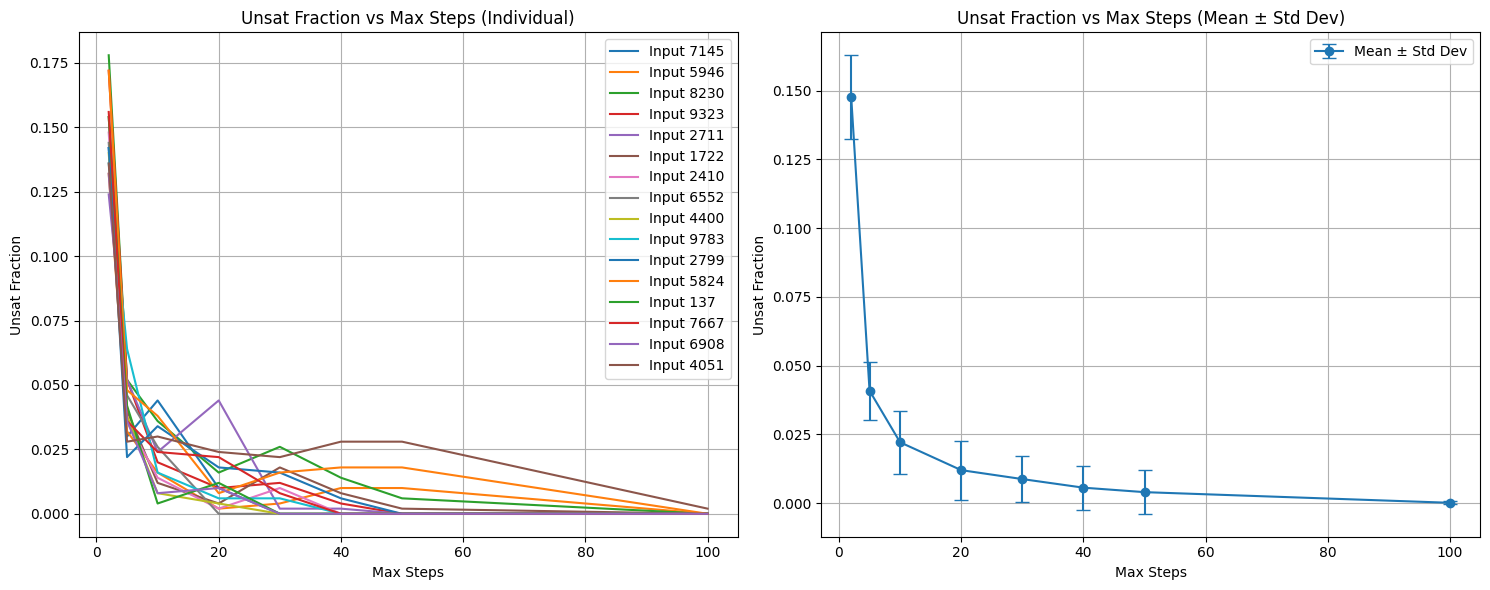

In [12]:
max_steps_values = [2, 5, 10, 20, 30, 40, 50, 100]
unsat_fractions = []

for steps in max_steps_values:
    state = model.initialize_state(x, y, init_mode)
    final_state, num_sweeps, unsat = model.relax(state, steps, ignore_right=0)
    unsat_fraction = unsat.mean(dim=-1, dtype=torch.float32).cpu().numpy()
    unsat_fractions.append(unsat_fraction)

# print("Unsat fractions for each max_steps:")
# for steps, fractions in zip(max_steps_values, unsat_fractions):
#     print(f"max_steps={steps:<3}:\n{fractions}")
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Subplot 1: Individual batch elements
plt.subplot(1, 2, 1)
for b in range(len(unsat_fractions[0])):  # Iterate over batch elements
    plt.plot(
        max_steps_values,
        [unsat_fractions[i][b, 0] for i in range(len(max_steps_values))],
        label=f"Input {idxs[b]}",
    )
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Individual)")
plt.legend()
plt.grid(True)

# Subplot 2: Mean and standard deviation
plt.subplot(1, 2, 2)
mean_unsat = [unsat.mean(axis=0)[0] for unsat in unsat_fractions]
std_unsat = [unsat.std(axis=0)[0] for unsat in unsat_fractions]
plt.errorbar(
    max_steps_values,
    mean_unsat,
    yerr=std_unsat,
    fmt="-o",
    capsize=5,
    label="Mean ± Std Dev",
)
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Mean ± Std Dev)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

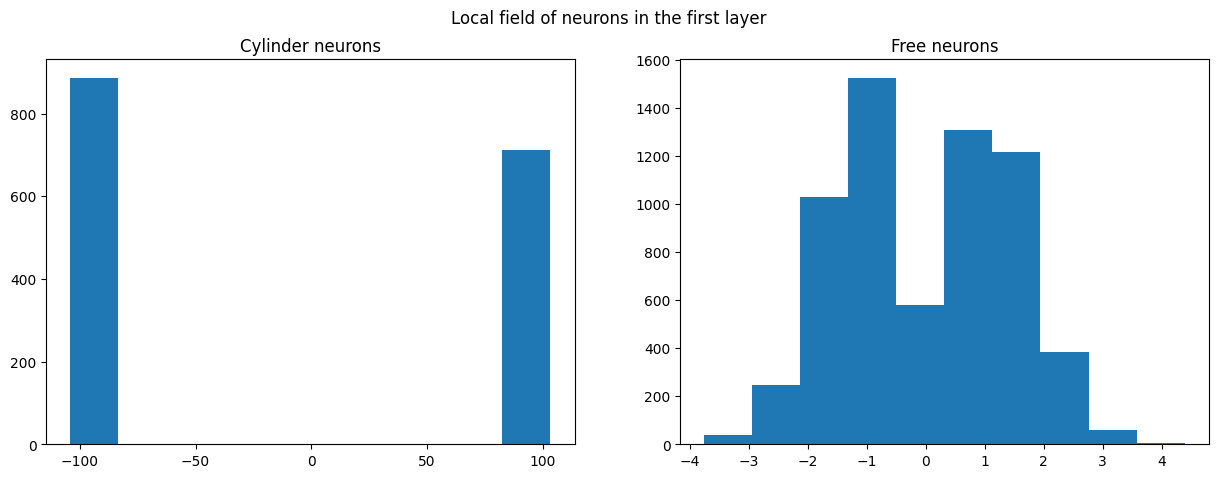

In [13]:
from matplotlib import pyplot as plt

fields = model.local_field(final_state, ignore_right=0)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(fields[:, 0, :N].flatten().cpu())
axs[1].hist(fields[:, 0, N:H].flatten().cpu())
fig.suptitle("Local field of neurons in the first layer")
axs[0].set_title("Cylinder neurons")
axs[1].set_title("Free neurons")
plt.show()

In [14]:
logs = handler.evaluate(x, y, max_steps)
print("Accuracy on batch:")
print(logs["overall_accuracy"])

Accuracy on batch:
0.0625


#### After Learning Step

In [16]:
state = model.initialize_state(x, y, init_mode)
final_state, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
made_update = model.perceptron_rule(final_state)

In [17]:
state = model.initialize_state(x, y, init_mode)
final_state, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
_, neurons, readout, _ = model.split_state(final_state)
label = y.argmax(dim=1)
pred = readout.argmax(dim=1)

print("Fraction usat (B, L+1):")
print(unsat.mean(dim=-1, dtype=torch.float32))

print("\nSimilarity of ferromagnetic cylinder with input (B,):")
print(torch.mean(neurons[:, :, :N] == x.unsqueeze(1), dim=-1, dtype=torch.float32))

print("\nReadout shows correct label (B,):")
print(pred == label)

Fraction usat (B, L+1):
tensor([[1.8e-02, 0.0e+00],
        [1.0e-02, 0.0e+00],
        [8.0e-03, 0.0e+00],
        [1.0e-02, 0.0e+00],
        [1.4e-02, 0.0e+00],
        [1.8e-02, 0.0e+00],
        [6.0e-03, 0.0e+00],
        [2.2e-02, 0.0e+00],
        [6.0e-03, 0.0e+00],
        [1.2e-02, 0.0e+00],
        [1.2e-02, 0.0e+00],
        [3.0e-02, 0.0e+00],
        [2.4e-02, 0.0e+00],
        [8.0e-03, 0.0e+00],
        [8.0e-03, 0.0e+00],
        [1.6e-02, 0.0e+00]], device='mps:0')

Similarity of ferromagnetic cylinder with input (B,):
tensor([[1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00],
        [1.0e+00]], device='mps:0')

Readout shows correct label (B,):
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, 

In [18]:
print("Overlap of Wback prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum(
        "bi,bi->b", model.W_back[:H, label].transpose(0, 1), neurons[:, -1, :H]
    )
    / model.W_back[:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum(
        "bi,bi->b", model.W_back[N:H, label].transpose(0, 1), neurons[:, -1, N:H]
    )
    / model.W_back[N:H, label].transpose(0, 1).norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[:H, range(C)].transpose(0, 1),
        neurons[:, -1, :H],
    )
    / model.W_back[:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_back[N:H, range(C)].transpose(0, 1),
        neurons[:, -1, N:H],
    )
    / model.W_back[N:H, range(C)].transpose(0, 1).norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)

print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wback prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([1.1e-01, -7.6e-02, -3.2e-02, 7.9e-03, 4.2e-02, -5.5e-02, -9.1e-02, -5.6e-02, -8.3e-02, 2.2e-02, -5.3e-02, -4.8e-02,
        2.2e-02, 2.0e-02, -1.3e-02, -1.3e-02], device='mps:0')
Only free neurons:
tensor([1.2e-01, -9.7e-02, -2.7e-03, 4.7e-02, 2.7e-02, -7.4e-02, -1.1e-01, -4.8e-02, -1.1e-01, 4.6e-02, -5.2e-02, -3.7e-02,
        9.4e-03, -4.6e-02, 1.0e-02, -5.1e-02], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-9.3e-03, -4.1e-03, -1.8e-02, -3.9e-02, 1.1e-02, -1.8e-02, 1.6e-02, -1.3e-02, -1.3e-02, -8.0e-03, -2.5e-02, -1.2e-02,
        7.5e-03, -4.1e-04, 1.6e-02, -1.2e-02], device='mps:0')
Only free neurons:
tensor([-1.6e-02,  6.5e-03, -1.7e-02, -3.7e-02,  8.2e-03, -2.4e-02,  1.4e-02,
        -2.0e-02, -1.8e-02, -1.9e-02, -2.7e-02, -1.6e-02, -2.5e-03,  1.1e-05,
         9.5e-03, -1.6e-02], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[1.8e-02, -3.2e-02, -4.1e-02, 

In [19]:
print("Overlap of Wforth prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum("bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H])
    / model.W_forth[label, :H].norm(dim=1)
    / neurons[:, -1, :H].norm(dim=1)
)
correct_overlap_free = (
    torch.einsum("bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H])
    / model.W_forth[label, N:H].norm(dim=1)
    / neurons[:, -1, N:H].norm(dim=1)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), :H],
        neurons[:, -1, :H],
    )
    / model.W_forth[range(C), :H].norm(dim=1)[None, :]
    / neurons[:, -1, :H].norm(dim=1)[:, None]
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc",
        model.W_forth[range(C), N:H],
        neurons[:, -1, N:H],
    )
    / model.W_forth[range(C), N:H].norm(dim=1)[None, :]
    / neurons[:, -1, N:H].norm(dim=1)[:, None]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wforth prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([-1.1e-01, -2.4e-04, -2.1e-01, -2.0e-01,  2.0e-01, -2.3e-01, -4.9e-02,
        -1.7e-01, -2.5e-01, -8.3e-02,  1.8e-02, -8.8e-02, -1.4e-01, -1.3e-01,
        -2.0e-01, -7.0e-02], device='mps:0')
Only free neurons:
tensor([-1.0e-01, 5.0e-03, -1.7e-01, -1.6e-01, 2.0e-01, -2.5e-01, -6.1e-02, -1.4e-01, -2.5e-01, -4.8e-02, 4.9e-02, -5.6e-02,
        -1.3e-01, -1.5e-01, -1.7e-01, -7.5e-02], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-3.3e-01, -2.9e-01, -3.6e-01, -4.1e-01, -2.3e-01, -3.3e-01, -3.4e-01, -3.5e-01, -3.4e-01, -3.4e-01, -3.6e-01, -3.3e-01,
        -3.2e-01, -3.3e-01, -3.6e-01, -3.0e-01], device='mps:0')
Only free neurons:
tensor([-3.1e-01, -2.6e-01, -3.4e-01, -4.0e-01, -2.2e-01, -3.2e-01, -3.3e-01, -3.3e-01, -3.3e-01, -3.3e-01, -3.3e-01, -3.1e-01,
        -3.0e-01, -3.0e-01, -3.5e-01, -2.8e-01], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[-3.8e-01, -3.5e

In [20]:
print("Logits magnitude.")
print("\n-- Correct class --")
correct_overlap_full = torch.einsum(
    "bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H]
)
correct_overlap_free = torch.einsum(
    "bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H]
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), :H], neurons[:, -1, :H]
)
overlaps_free = torch.einsum(
    "ci,bi->bc", model.W_forth[range(C), N:H], neurons[:, -1, N:H]
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Logits magnitude.

-- Correct class --
Full layer:
tensor([-3.6e+00, -7.3e-03, -6.6e+00, -6.2e+00,  6.1e+00, -7.5e+00, -1.5e+00,
        -5.3e+00, -7.8e+00, -2.6e+00,  5.4e-01, -2.7e+00, -4.8e+00, -4.0e+00,
        -6.4e+00, -2.2e+00], device='mps:0')
Only free neurons:
tensor([-2.5e+00, 1.2e-01, -4.2e+00, -3.8e+00, 4.9e+00, -6.2e+00, -1.5e+00, -3.6e+00, -6.3e+00, -1.1e+00, 1.2e+00, -1.4e+00,
        -3.3e+00, -3.7e+00, -4.3e+00, -1.9e+00], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-1.0e+01, -9.0e+00, -1.1e+01, -1.3e+01, -7.3e+00, -1.0e+01, -1.1e+01, -1.1e+01, -1.1e+01, -1.1e+01,
        -1.1e+01, -1.1e+01, -1.0e+01, -1.0e+01, -1.1e+01, -9.4e+00],
       device='mps:0')
Only free neurons:
tensor([-7.7e+00, -6.4e+00, -8.4e+00, -9.8e+00, -5.5e+00, -8.0e+00, -8.2e+00, -8.2e+00, -8.1e+00, -8.1e+00, -8.1e+00, -7.6e+00,
        -7.4e+00, -7.5e+00, -8.6e+00, -6.9e+00], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[-1.3e+01, -1.1e+01, -6.9e+00, -9.1e+00, -1.1

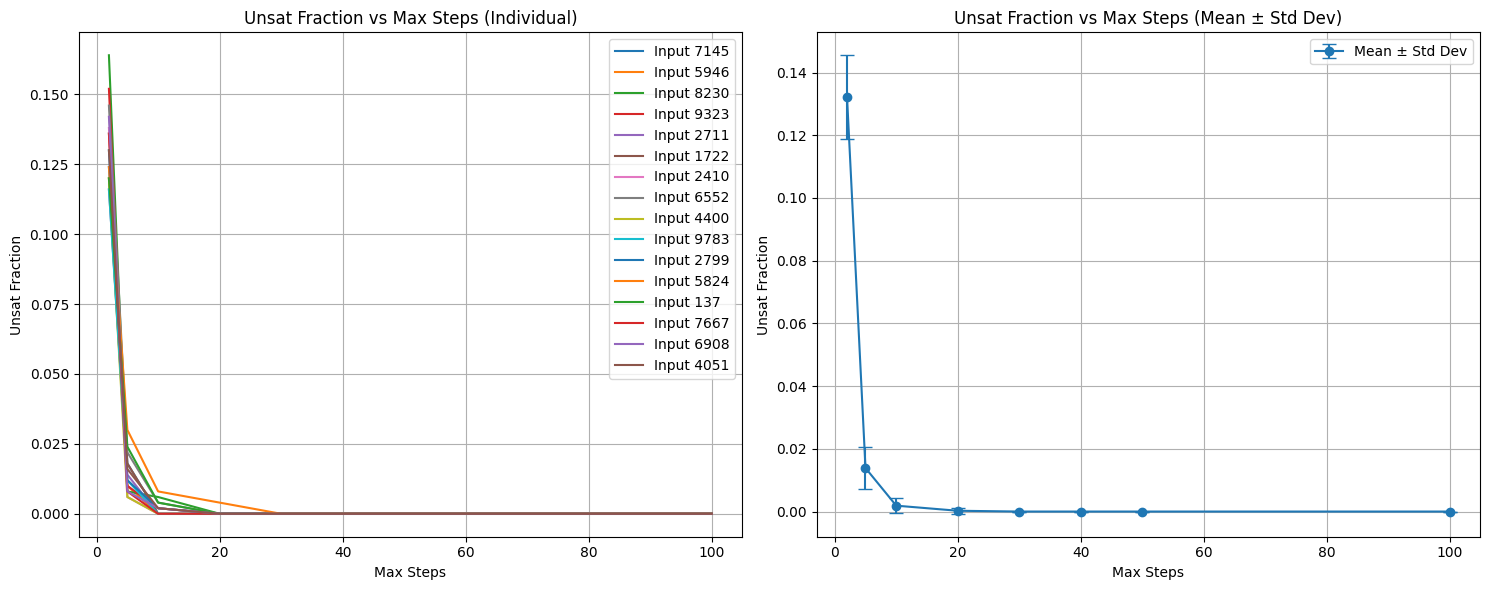

In [21]:
max_steps_values = [2, 5, 10, 20, 30, 40, 50, 100]
unsat_fractions = []

for steps in max_steps_values:
    state = model.initialize_state(x, y, init_mode)
    final_state, num_sweeps, unsat = model.relax(state, steps, ignore_right=0)
    unsat_fraction = unsat.mean(dim=-1, dtype=torch.float32).cpu().numpy()
    unsat_fractions.append(unsat_fraction)

# print("Unsat fractions for each max_steps:")
# for steps, fractions in zip(max_steps_values, unsat_fractions):
#     print(f"max_steps={steps:<3}:\n{fractions}")
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Subplot 1: Individual batch elements
plt.subplot(1, 2, 1)
for b in range(len(unsat_fractions[0])):  # Iterate over batch elements
    plt.plot(
        max_steps_values,
        [unsat_fractions[i][b, 0] for i in range(len(max_steps_values))],
        label=f"Input {idxs[b]}",
    )
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Individual)")
plt.legend()
plt.grid(True)

# Subplot 2: Mean and standard deviation
plt.subplot(1, 2, 2)
mean_unsat = [unsat.mean(axis=0)[0] for unsat in unsat_fractions]
std_unsat = [unsat.std(axis=0)[0] for unsat in unsat_fractions]
plt.errorbar(
    max_steps_values,
    mean_unsat,
    yerr=std_unsat,
    fmt="-o",
    capsize=5,
    label="Mean ± Std Dev",
)
plt.xlabel("Max Steps")
plt.ylabel("Unsat Fraction")
plt.title("Unsat Fraction vs Max Steps (Mean ± Std Dev)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

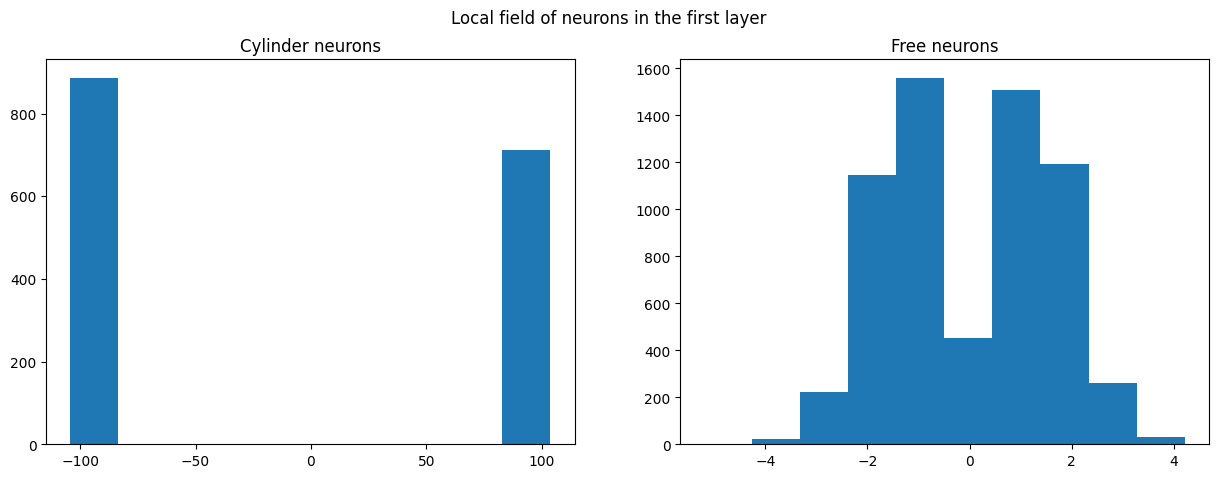

In [22]:
from matplotlib import pyplot as plt

fields = model.local_field(final_state, ignore_right=0)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(fields[:, 0, :N].flatten().cpu())
axs[1].hist(fields[:, 0, N:H].flatten().cpu())
fig.suptitle("Local field of neurons in the first layer")
axs[0].set_title("Cylinder neurons")
axs[1].set_title("Free neurons")
plt.show()

In [23]:
logs = handler.evaluate(x, y, max_steps)
print("Accuracy on batch:")
print(logs["overall_accuracy"])

Accuracy on batch:
0.875


### Relaxation

In [19]:
idxs = [1234]

x = train_inputs[idxs]
y = train_targets[idxs]
state = model.initialize_state(x, y, "zeros")

In [22]:
fields = model.local_field(state, ignore_right=0)
state[:, 1:-1, :] = torch.sign(fields)

In [6]:
fields = model.local_field(state, ignore_right=0)
# torch.sign(fields, out=state[:, 1:-1, :])
state[:, 1:-1, :] = torch.sign(fields)
print(state[0, 0])
print(state[0, 1, :C])

tensor([-1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,
         1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
        -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,
        -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,
        -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
        -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [44]:
model.fraction_unsat(state)[0, 1, :C]

tensor([False, False, False, False, False, False, False, False, False, False],
       device='mps:0')

### Train Step

In [114]:
idxs = [1234]

x = train_inputs[idxs]
y = train_targets[idxs]
state = model.initialize_state(x, y, "input")
final_state, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
_, neurons, readout, _ = model.split_state(final_state)
label = y.argmax(dim=1)
pred = readout.argmax(dim=1)

### Training

In [138]:
logs = handler.train_loop(
    num_epochs,
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
    eval_interval=eval_interval,
    eval_inputs=eval_inputs,
    eval_targets=eval_targets,
)

Final Train Accuracy: 0.80


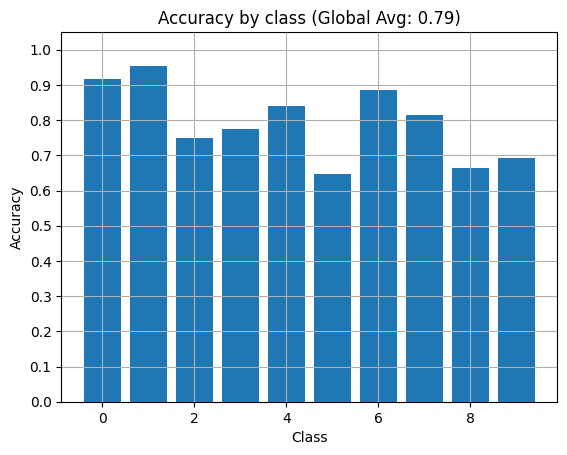

In [139]:
import matplotlib.pyplot as plt

from src.utils import plot_accuracy_by_class_barplot

train_metrics = handler.evaluate(train_inputs, train_targets, max_steps)
print(f"Final Train Accuracy: {train_metrics['overall_accuracy']:.2f}")
fig = plot_accuracy_by_class_barplot(train_metrics["accuracy_by_class"])
plt.show()

Final Eval Accuracy: 0.77


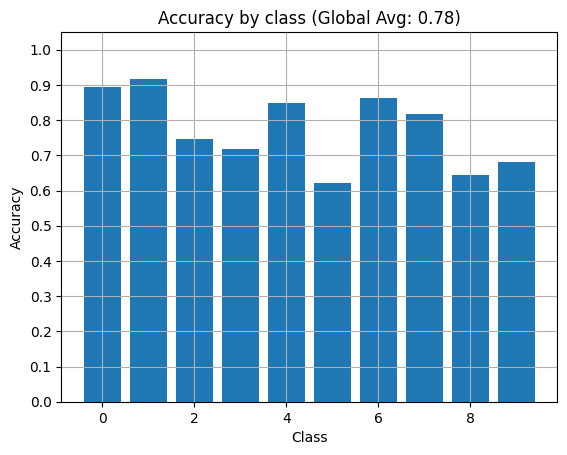

In [140]:
import matplotlib.pyplot as plt

from src.utils import plot_accuracy_by_class_barplot

eval_metrics = handler.evaluate(eval_inputs, eval_targets, max_steps)
print(f"Final Eval Accuracy: {eval_metrics['overall_accuracy']:.2f}")
fig = plot_accuracy_by_class_barplot(eval_metrics["accuracy_by_class"])
plt.show()

In [ ]:
out = model.inference(eval_inputs, max_steps)
logits = out[0]
predictions = torch.argmax(logits, dim=1)
gt = torch.argmax(eval_targets, dim=1)

In [ ]:
import torch.nn.functional as F

probas = F.softmax(logits, dim=1)
probas_wrong = probas[gt != predictions]
probas_right = probas[gt == predictions]

diff_wrong = (
    (
        probas_wrong.topk(2, dim=1).values[:, 0]
        - probas_wrong.topk(2, dim=1).values[:, 1]
    )
    .mean()
    .item()
)
diff_right = (
    (
        probas_right.topk(2, dim=1).values[:, 0]
        - probas_right.topk(2, dim=1).values[:, 1]
    )
    .mean()
    .item()
)

print(f"Average difference (wrong predictions): {diff_wrong}")
print(f"Average difference (correct predictions): {diff_right}")

Average difference (wrong predictions): 0.4420371651649475
Average difference (correct predictions): 0.8776503801345825


In [ ]:
proba_of_gt_wrong = probas_wrong[range(probas_wrong.size(0)), gt[gt != predictions]]
avg_proba_of_gt_wrong = proba_of_gt_wrong.mean().item()
print(
    f"Average probability of correct ground truth class among probas_wrong: {avg_proba_of_gt_wrong}"
)

Average probability of correct ground truth class among probas_wrong: 0.14338774979114532


In [ ]:
proba_of_gt_right = probas_right[range(probas_right.size(0)), gt[gt == predictions]]
avg_proba_of_gt_right = proba_of_gt_right.mean().item()
print(
    f"Average probability of correct ground truth class among probas_right: {avg_proba_of_gt_right}"
)

Average probability of correct ground truth class among probas_right: 0.924145519733429
